<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/ALR/AFRL_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Negative Log

In [ ]:
import os
import numpy as np
import imageio.v2 as imageio  # for TIFF reading
from tqdm import tqdm

# Parameters
num_views = 900
input_dir = '/content/drive/MyDrive/AFRL/raw_tiff_PH_pin2'
output_dir = '/content/drive/MyDrive/AFRL/negative_log/'
output_basename = 'view'

os.makedirs(output_dir, exist_ok=True)

# Loop through all views
for iv in tqdm(range(1, num_views + 1)):
    # Build input filename
    filename = f'FeOOH_NP_pin2_LFOV_PH_50sec_bin1_901_Export0{iv:03d}.tiff'
    filepath = os.path.join(input_dir, filename)

    # Read TIFF image and convert to float64
    data = imageio.imread(filepath).astype(np.float64)

    # Apply negative log transform
    with np.errstate(divide='ignore'):  # suppress log(0) warnings
        sino = -np.log(data)

    # Save as raw float32 binary file (filename has .tiff extension)
    output_filename = f'{output_basename}{iv:04d}.tiff'
    output_path = os.path.join(output_dir, output_filename)

    # Save the binary float32 values
    sino.astype(np.float32).tofile(output_path)


100%|██████████| 900/900 [05:38<00:00,  2.66it/s]


Negative Log Correction

In [ ]:
import os
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm

# --- CONFIGURATION ---
num_views = 900
num_channels = 1024
num_slices = 1024
bright_dataset_size = 10
dark_dataset_size = 10

# Set your paths
bright_dir = '/content/drive/MyDrive/AFRL/calibration_dataset/light_scans'
dark_dir = '/content/drive/MyDrive/AFRL/calibration_dataset/dark_scans'
log_input_dir = '/content/drive/MyDrive/AFRL/negative_log'
output_dir = '/content/drive/MyDrive/ARL/negative_log_corrected/'
output_basename = 'view'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# --- STEP 1: CALCULATE BRIGHT DATASET MEAN ---
bright_mean = 0
for i in range(1, bright_dataset_size + 1):
    filename = f'{bright_dir}/light_scan_{i:02d}.tiff'
    data = imageio.imread(filename).astype(np.float64)
    bright_mean += np.mean(data)

bright_mean /= bright_dataset_size
print(f"Bright dataset mean: {bright_mean}, -log(mean): {-np.log(bright_mean)}")

# --- STEP 2: CALCULATE DARK DATASET MEAN ---
dark_mean = 0
for i in range(1, dark_dataset_size + 1):
    filename = f'{dark_dir}/dark_scan_{i:02d}.tiff'
    data = imageio.imread(filename).astype(np.float64)
    dark_mean += np.mean(data)

dark_mean /= dark_dataset_size
print(f"Dark dataset mean: {dark_mean}, -log(mean): {-np.log(dark_mean)}")

# --- STEP 3: CALCULATE OFFSET ---
offset = -np.log((bright_mean - dark_mean) / dark_mean)
print(f"Offset value: {offset}")

# --- STEP 4: APPLY OFFSET TO LOG SINOGRAM FILES ---
for i in tqdm(range(1, num_views + 1)):
    input_file = os.path.join(log_input_dir, f'view0{i:03d}.tiff')
    output_file = os.path.join(output_dir, f'{output_basename}{i:04d}.tiff')

    # Read float32 binary data
    data = np.fromfile(input_file, dtype=np.float32).reshape((num_slices, num_channels))

    # Apply correction
    corrected_data = data - offset

    # Save as binary float32 file
    corrected_data.astype(np.float32).tofile(output_file)


Bright dataset mean: 51.85313873291015, -log(mean): -3.948415467711459
Dark dataset mean: 4.506961059570313, -log(mean): -1.5056231036823495
Offset value: -2.3518629877354393


100%|██████████| 900/900 [05:09<00:00,  2.91it/s]


In [ ]:
import os
import numpy as np
from PIL import Image

# Define root directory
root_dir = '/content/drive/MyDrive/AFRL/calibration_dataset'

# Create target folders inside Google Drive
dark_dir = os.path.join(root_dir, 'dark_scans')
light_dir = os.path.join(root_dir, 'light_scans')
os.makedirs(dark_dir, exist_ok=True)
os.makedirs(light_dir, exist_ok=True)

# Image size
image_size = (512, 512)

# Create 10 dark scan images
for i in range(10):
    dark_image = np.random.normal(loc=5, scale=2, size=image_size)  # Low-intensity noise
    dark_image = np.clip(dark_image, 0, 255).astype(np.uint8)
    im = Image.fromarray(dark_image)
    im.save(os.path.join(dark_dir, f'dark_scan_{i+1:02d}.tiff'))

# Create 10 light scan images
for i in range(10):
    x = np.linspace(-1, 1, image_size[0])
    y = np.linspace(-1, 1, image_size[1])
    xv, yv = np.meshgrid(x, y)
    light_image = 200 * (1 - np.sqrt(xv**2 + yv**2))  # Bright center
    light_image += np.random.normal(loc=0, scale=5, size=image_size)
    light_image = np.clip(light_image, 0, 255).astype(np.uint8)
    im = Image.fromarray(light_image)
    im.save(os.path.join(light_dir, f'light_scan_{i+1:02d}.tiff'))

print("10 dark scans and 10 light scans created successfully.")



10 dark scans and 10 light scans created successfully.


Create Sino

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
NumViews = 900
NumChannels = 1024
NumSlices = 1024
BlockSize = 128
Nblocks = NumSlices // BlockSize
number_view_subsets = 4
SV_block_size = 25

# Directories
input_dir = '/content/drive/MyDrive/ARL/negative_log_corrected'  # Example path for preloaded data
output_dir = '/content/drive/MyDrive/ARL/sino/'
output_basename = 'afrl_viewgroup'

os.makedirs(output_dir, exist_ok=True)

# Placeholder for one block of slices
sino_block = np.zeros((BlockSize, NumChannels, NumViews), dtype=np.float32)

# --- PROCESSING ---
for blkid in range(Nblocks):
    print(f"Processing block {blkid+1}/{Nblocks}")
    slidx = np.arange(blkid * BlockSize, (blkid + 1) * BlockSize)

    # Step 1: Load current block of slices across all views
    for iv in range(NumViews):
        view_filename = os.path.join(input_dir, f'view{iv+1:04d}.tiff')
        with open(view_filename, 'rb') as fp:
            data = np.fromfile(fp, dtype=np.float32).reshape(NumSlices, NumChannels)
            sino_block[:, :, iv] = data[slidx, :]

    # Step 2: Process each slice
    for sl in range(BlockSize):
        slice_index = blkid * BlockSize + sl
        for view_group_index in range(1, number_view_subsets + 1):
            output_file = os.path.join(
                output_dir,
                f"{output_basename}_{view_group_index}_slice{slice_index+1:04d}.2Dsinodata"
            )
            with open(output_file, 'wb') as fp:
                for i in range(NumViews // (number_view_subsets * SV_block_size)):
                    start_index = (view_group_index - 1) * SV_block_size + number_view_subsets * SV_block_size * i
                    end_index = start_index + SV_block_size
                    slice_views = sino_block[sl, :, start_index:end_index]
                    fp.write(slice_views.astype(np.float32).tobytes())


Processing block 1/8
Processing block 2/8
Processing block 3/8
Processing block 4/8
Processing block 5/8
Processing block 6/8
Processing block 7/8
Processing block 8/8


create wght

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Configuration
NumViews = 900
NumChannels = 1024
NumSlices = 1024
number_view_groups = 4

# Directories
input_dir = '/content/drive/MyDrive/ARL/sino'  # Placeholder path for .2Dsinodata
output_dir = '/content/drive/MyDrive/ARL/wght/'
output_basename = 'afrl_viewgroup'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load reference sinogram to compute variance
ref_file = '/content/drive/MyDrive/ARL/negative_log_corrected/view0450.tiff'
with open(ref_file, 'rb') as fp:
    data = np.fromfile(fp, dtype=np.float32).reshape((NumSlices, NumChannels))

cropped_dataset = data[899:1024, :]  # MATLAB 900:1024 --> Python 899:1024
variance = np.var(cropped_dataset)
print(f"Computed variance: {variance}")

# Step 2: Loop through all slices and view groups to compute weights
for i in tqdm(range(1, NumSlices + 1), desc="Processing slices"):
    for view_group_index in range(1, number_view_groups + 1):
        sino_file = os.path.join(input_dir, f'afrl_viewgroup_{view_group_index}_slice{i:04d}.2Dsinodata')
        with open(sino_file, 'rb') as fp:
            sino = np.fromfile(fp, dtype=np.float32).reshape((NumChannels, NumViews // number_view_groups))

        # Compute weights
        weight = np.exp(-sino) / variance

        # Save weights
        output_file = os.path.join(output_dir, f'{output_basename}_{view_group_index}_slice{i:04d}.2Dweightdata')
        with open(output_file, 'wb') as fp:
            fp.write(weight.astype(np.float32).tobytes())


Computed variance: 0.0009520172025077045


Processing slices: 100%|██████████| 1024/1024 [05:47<00:00,  2.95it/s]


FBP

✅ Reconstructed image saved to: /content/drive/MyDrive/AFRL/Output/slice0700_FBP.tiff


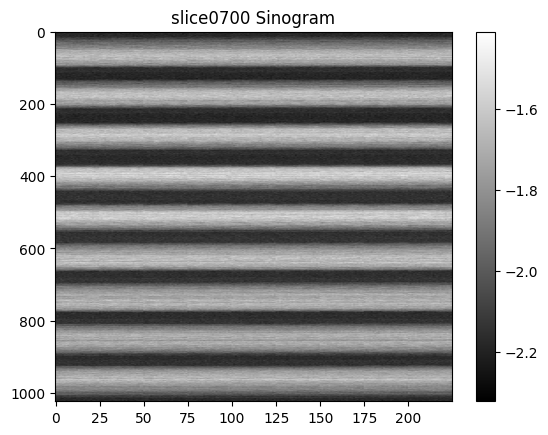

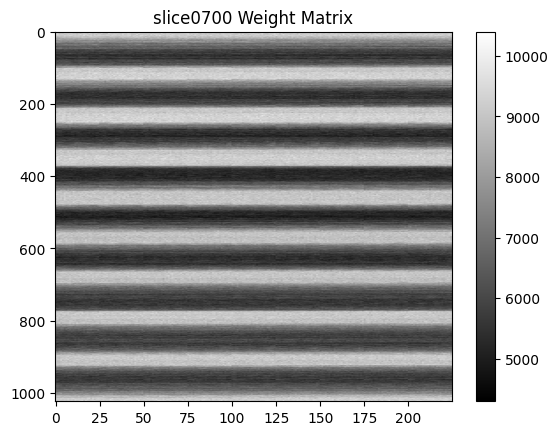

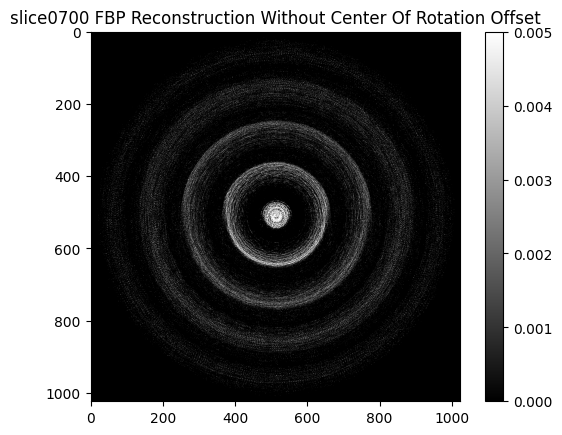

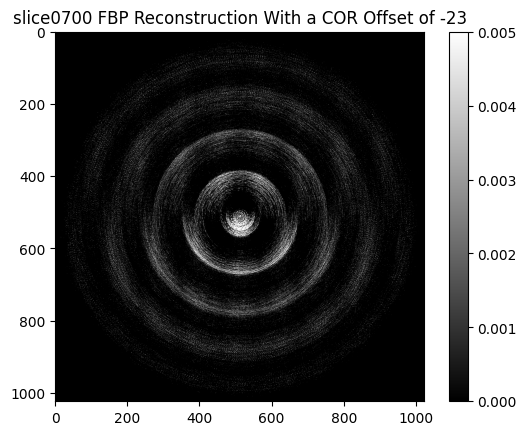

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon
from PIL import Image
import os

# Parameters
NumViews = 900
NumChannels = 1024
subsampling_factor = 4
view_count = NumViews // subsampling_factor

# File paths
sino_path = '/content/drive/MyDrive/AFRL/sino/afrl_viewgroup_2_slice0700.2Dsinodata'
weight_path = '/content/drive/MyDrive/AFRL/wght/afrl_viewgroup_1_slice0700.2Dweightdata'
output_path = os.path.expanduser('/content/drive/MyDrive/AFRL/Output/slice0700_FBP.tiff')

# Load sinogram
sino = np.fromfile(sino_path, dtype=np.float32).reshape((NumChannels, view_count))

# Visualize sinogram
plt.figure(1)
plt.title('slice0700 Sinogram')
plt.imshow(sino, cmap='gray', aspect='auto')
plt.colorbar()

# Load weight matrix
weight = np.fromfile(weight_path, dtype=np.float32).reshape((NumChannels, view_count))

# Visualize weight
plt.figure(2)
plt.title('slice0700 Weight Matrix')
plt.imshow(weight, cmap='gray', aspect='auto')
plt.colorbar()

# Generate angle list for iradon
theta = np.linspace(0., 180., view_count, endpoint=False)

# Reconstruction without COR shift
recon_no_shift = iradon(sino, theta=theta, filter_name='ramp', interpolation='linear', circle=True, output_size=1024)

plt.figure(3)
plt.title('slice0700 FBP Reconstruction Without Center Of Rotation Offset')
plt.imshow(recon_no_shift, cmap='gray', vmin=0, vmax=0.005)
plt.colorbar()

# Reconstruction with COR shift of -23 pixels
sino_shifted = np.roll(sino, shift=-23, axis=0)
recon_shifted = iradon(sino_shifted, theta=theta, filter_name='ramp', interpolation='linear', circle=True, output_size=1024)

plt.figure(4)
plt.title('slice0700 FBP Reconstruction With a COR Offset of -23')
plt.imshow(recon_shifted, cmap='gray', vmin=0, vmax=0.005)
plt.colorbar()

# Post-process: clip negatives and normalize
recon_processed = np.clip(recon_shifted, 0, None)  # clip negatives
recon_processed = (recon_processed / 0.005) * 255  # normalize to 0-255
recon_uint8 = recon_processed.astype(np.uint8)

# Save image
Image.fromarray(recon_uint8).save(output_path)
print(f"✅ Reconstructed image saved to: {output_path}")


Data loaded. Shape: (1024, 1024, 900)


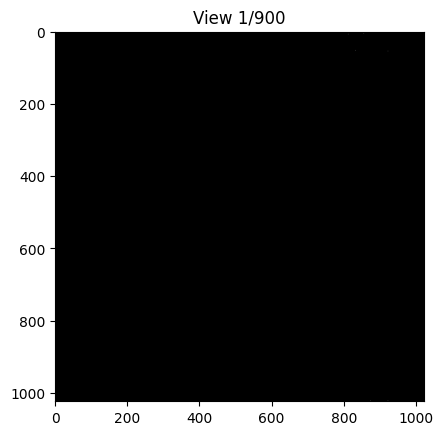

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from matplotlib.animation import FuncAnimation

# Parameters
N_views = 900
N_Slices = 1024
N_channels = 1024

# File prefix
fileprefix = os.path.expanduser('/content/drive/MyDrive/AFRL/negative_log_corrected/view')

# Initialize 3D array: shape (Slices, Channels, Views)
data = np.zeros((N_Slices, N_channels, N_views), dtype=np.float32)

# Load TIFF data into 3D array
for i in range(N_views):
    filename = f"{fileprefix}{i+1:04d}.tiff"
    with open(filename, 'rb') as f:
        raw = np.fromfile(f, dtype=np.float32, count=N_Slices * N_channels)
        data[:, :, i] = raw.reshape((N_Slices, N_channels))

print("Data loaded. Shape:", data.shape)

# === Visualization using animation (like implay) ===
fig, ax = plt.subplots()
img = ax.imshow(data[:, :, 0], cmap='gray', vmin=0, vmax=np.percentile(data, 99), animated=True)
plt.title("Slice Playback - Press ESC to stop")

def update(frame):
    img.set_array(data[:, :, frame])
    ax.set_title(f"View {frame+1}/{N_views}")
    return [img]

ani = FuncAnimation(fig, update, frames=N_views, interval=50, blit=True)
plt.show()


In [10]:
ani.save("/content/drive/MyDrive/AFRL/Output/reconstruction_playback.mp4", fps=20)
